In [1]:
import librosa
from librosa import display

data, sampling_rate = librosa.load('/home/sisir/BDA/ravdess/Actor_01/03-01-01-01-01-01-01.wav')

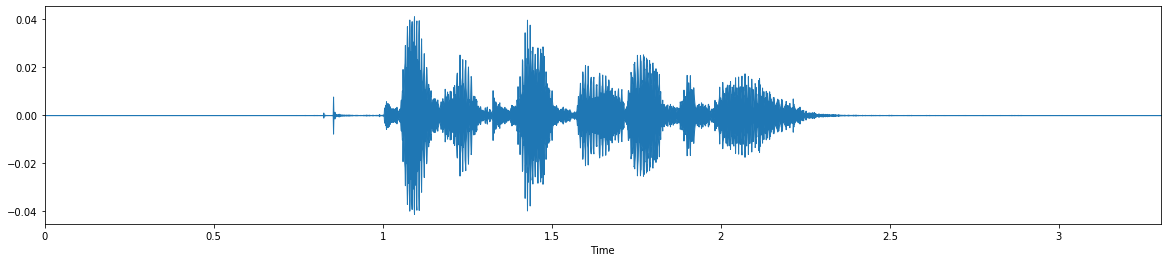

In [2]:
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt

plt.figure(figsize=(20,4))
librosa.display.waveplot(data,sr=sampling_rate)

In [44]:
import time
import numpy as np

path = '/home/sisir/BDA/ravdess/'
lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        file = int(file[7:8]) - 1 
        arr = mfccs, file
        lst.append(arr)
      # If the file is not valid, skip it
      except ValueError:
        continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 106.18045687675476 seconds ---


In [45]:
X, y = zip(*lst)

In [46]:
X = np.asarray(X)
y = np.asarray(y)

X.shape, y.shape

((1440, 40), (1440,))

In [47]:
# Decision Tree Classifier

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [48]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()

In [49]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [50]:
predictions = dtree.predict(X_test)

In [51]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.21      0.33      0.26        27
           1       0.44      0.39      0.41        57
           2       0.31      0.30      0.30        57
           3       0.35      0.38      0.36        56
           4       0.52      0.45      0.49        55
           5       0.42      0.41      0.41        61
           6       0.41      0.37      0.39        62
           7       0.38      0.40      0.39        57

    accuracy                           0.38       432
   macro avg       0.38      0.38      0.38       432
weighted avg       0.39      0.38      0.39       432

[[ 9 11  1  3  0  0  2  1]
 [17 22  5  4  2  4  2  1]
 [ 3  3 17  4  5  8  5 12]
 [ 7  6  4 21  2  7  6  3]
 [ 0  0  4  4 25  8  5  9]
 [ 0  6  6  9  4 25  7  4]
 [ 4  2 10  7  5  3 23  8]
 [ 2  0  8  8  5  5  6 23]]


In [52]:
# Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

rforest = RandomForestClassifier(criterion="gini", max_depth=10, max_features="log2", 
                                 max_leaf_nodes = 100, min_samples_leaf = 3, min_samples_split = 20, 
                                 n_estimators= 22000, random_state= 5)

In [53]:
rforest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='log2',
                       max_leaf_nodes=100, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=22000,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)

In [54]:
predictions = rforest.predict(X_test)

In [55]:
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.45      0.84      0.59        57
           2       0.50      0.33      0.40        57
           3       0.35      0.32      0.34        56
           4       0.59      0.58      0.59        55
           5       0.49      0.46      0.47        61
           6       0.51      0.45      0.48        62
           7       0.49      0.60      0.54        57

    accuracy                           0.48       432
   macro avg       0.42      0.45      0.43       432
weighted avg       0.45      0.48      0.46       432

[[ 0 14  1  6  0  0  2  4]
 [ 1 48  2  1  0  0  3  2]
 [ 0  1 19  6  6 13  3  9]
 [ 0 23  1 18  0  8  3  3]
 [ 0  4  3  1 32  3  7  5]
 [ 0  2  6 11  6 28  4  4]
 [ 0  9  2  6  6  2 28  9]
 [ 0  5  4  2  4  3  5 34]]


In [56]:
# Convolution Neural Networks

x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [57]:
x_traincnn.shape, x_testcnn.shape

((1008, 40, 1), (432, 40, 1))

In [87]:
import keras
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

model = Sequential()

model.add(Conv1D(128, 5,padding='same', input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.005, rho=0.9, decay=0.01)

In [88]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 40, 128)           768       
_________________________________________________________________
activation_22 (Activation)   (None, 40, 128)           0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 5, 128)            82048     
_________________________________________________________________
activation_23 (Activation)   (None, 5, 128)            0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 5, 128)           

In [89]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [90]:
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((1008, 40, 1), (1008,), (432, 40, 1), (432,))

In [91]:
cnn_model=model.fit(x_traincnn, y_train, batch_size=16, epochs=1000, validation_data=(x_testcnn, y_test))

Train on 1008 samples, validate on 432 samples
Epoch 1/1000
1008/1008 [==============================] - 2s 2ms/step - loss: 21.3589 - accuracy: 0.1687 - val_loss: 1.9584 - val_accuracy: 0.2662
Epoch 2/1000
1008/1008 [==============================] - 1s 1ms/step - loss: 2.0305 - accuracy: 0.2063 - val_loss: 1.9462 - val_accuracy: 0.2292
Epoch 3/1000
1008/1008 [==============================] - 1s 1ms/step - loss: 1.8933 - accuracy: 0.2728 - val_loss: 1.8062 - val_accuracy: 0.3194
Epoch 4/1000
1008/1008 [==============================] - 1s 1ms/step - loss: 1.7757 - accuracy: 0.3155 - val_loss: 1.8252 - val_accuracy: 0.2778
Epoch 5/1000
1008/1008 [==============================] - 1s 1ms/step - loss: 1.7464 - accuracy: 0.3175 - val_loss: 1.7118 - val_accuracy: 0.3588
Epoch 6/1000
1008/1008 [==============================] - 1s 1ms/step - loss: 1.6802 - accuracy: 0.3730 - val_loss: 1.7265 - val_accuracy: 0.3634
Epoch 7/1000
1008/1008 [==============================] - 1s 1ms/step - loss

1008/1008 [==============================] - 1s 971us/step - loss: 0.9198 - accuracy: 0.6657 - val_loss: 1.4303 - val_accuracy: 0.4861
Epoch 112/1000
1008/1008 [==============================] - 1s 953us/step - loss: 0.9415 - accuracy: 0.6647 - val_loss: 1.4315 - val_accuracy: 0.4815
Epoch 113/1000
1008/1008 [==============================] - 1s 946us/step - loss: 0.8941 - accuracy: 0.6984 - val_loss: 1.4359 - val_accuracy: 0.4815
Epoch 114/1000
1008/1008 [==============================] - 1s 957us/step - loss: 0.9142 - accuracy: 0.6855 - val_loss: 1.4340 - val_accuracy: 0.4861
Epoch 115/1000
1008/1008 [==============================] - 1s 961us/step - loss: 0.8888 - accuracy: 0.6905 - val_loss: 1.4326 - val_accuracy: 0.4884
Epoch 116/1000
1008/1008 [==============================] - 1s 966us/step - loss: 0.9082 - accuracy: 0.6915 - val_loss: 1.4254 - val_accuracy: 0.4838
Epoch 117/1000
1008/1008 [==============================] - 1s 955us/step - loss: 0.9013 - accuracy: 0.6845 - val_l

Epoch 166/1000
1008/1008 [==============================] - 1s 1ms/step - loss: 0.8498 - accuracy: 0.6875 - val_loss: 1.4267 - val_accuracy: 0.4769
Epoch 167/1000
1008/1008 [==============================] - 1s 952us/step - loss: 0.8340 - accuracy: 0.7044 - val_loss: 1.4374 - val_accuracy: 0.4931
Epoch 168/1000
1008/1008 [==============================] - 1s 1ms/step - loss: 0.8388 - accuracy: 0.6974 - val_loss: 1.4308 - val_accuracy: 0.4931
Epoch 169/1000
1008/1008 [==============================] - 1s 971us/step - loss: 0.8340 - accuracy: 0.7103 - val_loss: 1.4322 - val_accuracy: 0.4884
Epoch 170/1000
1008/1008 [==============================] - 1s 947us/step - loss: 0.8287 - accuracy: 0.7044 - val_loss: 1.4315 - val_accuracy: 0.4907
Epoch 171/1000
1008/1008 [==============================] - 1s 943us/step - loss: 0.8470 - accuracy: 0.6994 - val_loss: 1.4341 - val_accuracy: 0.4884
Epoch 172/1000
1008/1008 [==============================] - 1s 950us/step - loss: 0.8429 - accuracy: 0.7

Epoch 221/1000
1008/1008 [==============================] - 1s 965us/step - loss: 0.8024 - accuracy: 0.7232 - val_loss: 1.4393 - val_accuracy: 0.4815
Epoch 222/1000
1008/1008 [==============================] - 1s 950us/step - loss: 0.7860 - accuracy: 0.7282 - val_loss: 1.4417 - val_accuracy: 0.4977
Epoch 223/1000
1008/1008 [==============================] - 1s 936us/step - loss: 0.8008 - accuracy: 0.7044 - val_loss: 1.4407 - val_accuracy: 0.4977
Epoch 224/1000
1008/1008 [==============================] - 1s 963us/step - loss: 0.7895 - accuracy: 0.7272 - val_loss: 1.4405 - val_accuracy: 0.4907
Epoch 225/1000
1008/1008 [==============================] - 1s 945us/step - loss: 0.7924 - accuracy: 0.7272 - val_loss: 1.4439 - val_accuracy: 0.4907
Epoch 226/1000
1008/1008 [==============================] - 1s 966us/step - loss: 0.8163 - accuracy: 0.7044 - val_loss: 1.4326 - val_accuracy: 0.4884
Epoch 227/1000
1008/1008 [==============================] - 1s 957us/step - loss: 0.7763 - accuracy:

Epoch 276/1000
1008/1008 [==============================] - 1s 962us/step - loss: 0.7679 - accuracy: 0.7202 - val_loss: 1.4421 - val_accuracy: 0.4977
Epoch 277/1000
1008/1008 [==============================] - 1s 951us/step - loss: 0.7766 - accuracy: 0.7341 - val_loss: 1.4374 - val_accuracy: 0.4977
Epoch 278/1000
1008/1008 [==============================] - 1s 940us/step - loss: 0.7449 - accuracy: 0.7569 - val_loss: 1.4443 - val_accuracy: 0.5023
Epoch 279/1000
1008/1008 [==============================] - 1s 939us/step - loss: 0.7313 - accuracy: 0.7599 - val_loss: 1.4453 - val_accuracy: 0.5000
Epoch 280/1000
1008/1008 [==============================] - 1s 951us/step - loss: 0.7461 - accuracy: 0.7391 - val_loss: 1.4406 - val_accuracy: 0.5023
Epoch 281/1000
1008/1008 [==============================] - 1s 950us/step - loss: 0.7675 - accuracy: 0.7351 - val_loss: 1.4488 - val_accuracy: 0.4977
Epoch 282/1000
1008/1008 [==============================] - 1s 958us/step - loss: 0.7570 - accuracy:

Epoch 331/1000
1008/1008 [==============================] - 1s 956us/step - loss: 0.7631 - accuracy: 0.7282 - val_loss: 1.4475 - val_accuracy: 0.4977
Epoch 332/1000
1008/1008 [==============================] - 1s 949us/step - loss: 0.7358 - accuracy: 0.7589 - val_loss: 1.4490 - val_accuracy: 0.5023
Epoch 333/1000
1008/1008 [==============================] - 1s 1ms/step - loss: 0.7298 - accuracy: 0.7520 - val_loss: 1.4470 - val_accuracy: 0.5023
Epoch 334/1000
1008/1008 [==============================] - 1s 1ms/step - loss: 0.7319 - accuracy: 0.7460 - val_loss: 1.4502 - val_accuracy: 0.4954
Epoch 335/1000
1008/1008 [==============================] - 1s 1ms/step - loss: 0.7391 - accuracy: 0.7490 - val_loss: 1.4477 - val_accuracy: 0.5023
Epoch 336/1000
1008/1008 [==============================] - 1s 1ms/step - loss: 0.7394 - accuracy: 0.7312 - val_loss: 1.4497 - val_accuracy: 0.5023
Epoch 337/1000
1008/1008 [==============================] - 1s 941us/step - loss: 0.7468 - accuracy: 0.7252 

Epoch 386/1000
1008/1008 [==============================] - 1s 1ms/step - loss: 0.6943 - accuracy: 0.7619 - val_loss: 1.4484 - val_accuracy: 0.5162
Epoch 387/1000
1008/1008 [==============================] - 1s 947us/step - loss: 0.7191 - accuracy: 0.7421 - val_loss: 1.4473 - val_accuracy: 0.5185
Epoch 388/1000
1008/1008 [==============================] - 1s 963us/step - loss: 0.7112 - accuracy: 0.7500 - val_loss: 1.4423 - val_accuracy: 0.5139
Epoch 389/1000
1008/1008 [==============================] - 1s 951us/step - loss: 0.7372 - accuracy: 0.7470 - val_loss: 1.4466 - val_accuracy: 0.5116
Epoch 390/1000
1008/1008 [==============================] - 1s 1ms/step - loss: 0.7061 - accuracy: 0.7569 - val_loss: 1.4487 - val_accuracy: 0.5162
Epoch 391/1000
1008/1008 [==============================] - 1s 967us/step - loss: 0.6847 - accuracy: 0.7619 - val_loss: 1.4481 - val_accuracy: 0.5093
Epoch 392/1000
1008/1008 [==============================] - 1s 975us/step - loss: 0.7306 - accuracy: 0.7

1008/1008 [==============================] - 1s 956us/step - loss: 0.6653 - accuracy: 0.7619 - val_loss: 1.4522 - val_accuracy: 0.5069
Epoch 497/1000
1008/1008 [==============================] - 1s 905us/step - loss: 0.6927 - accuracy: 0.7659 - val_loss: 1.4554 - val_accuracy: 0.5116
Epoch 498/1000
1008/1008 [==============================] - 1s 957us/step - loss: 0.6927 - accuracy: 0.7599 - val_loss: 1.4560 - val_accuracy: 0.5116
Epoch 499/1000
1008/1008 [==============================] - 1s 952us/step - loss: 0.7043 - accuracy: 0.7599 - val_loss: 1.4526 - val_accuracy: 0.5093
Epoch 500/1000
1008/1008 [==============================] - 1s 982us/step - loss: 0.6877 - accuracy: 0.7560 - val_loss: 1.4505 - val_accuracy: 0.5139
Epoch 501/1000
1008/1008 [==============================] - 1s 942us/step - loss: 0.6768 - accuracy: 0.7530 - val_loss: 1.4540 - val_accuracy: 0.5069
Epoch 502/1000
1008/1008 [==============================] - 1s 999us/step - loss: 0.6721 - accuracy: 0.7619 - val_l

Epoch 551/1000
1008/1008 [==============================] - 1s 858us/step - loss: 0.6702 - accuracy: 0.7599 - val_loss: 1.4534 - val_accuracy: 0.5139
Epoch 552/1000
1008/1008 [==============================] - 1s 834us/step - loss: 0.6830 - accuracy: 0.7510 - val_loss: 1.4596 - val_accuracy: 0.5162
Epoch 553/1000
1008/1008 [==============================] - 1s 812us/step - loss: 0.6571 - accuracy: 0.7669 - val_loss: 1.4639 - val_accuracy: 0.5139
Epoch 554/1000
1008/1008 [==============================] - 1s 864us/step - loss: 0.6696 - accuracy: 0.7649 - val_loss: 1.4595 - val_accuracy: 0.5116
Epoch 555/1000
1008/1008 [==============================] - 1s 848us/step - loss: 0.6730 - accuracy: 0.7649 - val_loss: 1.4573 - val_accuracy: 0.5116
Epoch 556/1000
1008/1008 [==============================] - 1s 797us/step - loss: 0.6671 - accuracy: 0.7609 - val_loss: 1.4566 - val_accuracy: 0.5023
Epoch 557/1000
1008/1008 [==============================] - 1s 858us/step - loss: 0.6628 - accuracy:

Epoch 660/1000
1008/1008 [==============================] - 1s 864us/step - loss: 0.6549 - accuracy: 0.7887 - val_loss: 1.4634 - val_accuracy: 0.5116
Epoch 661/1000
1008/1008 [==============================] - 1s 818us/step - loss: 0.6871 - accuracy: 0.7569 - val_loss: 1.4613 - val_accuracy: 0.5162
Epoch 662/1000
1008/1008 [==============================] - 1s 854us/step - loss: 0.6457 - accuracy: 0.7708 - val_loss: 1.4625 - val_accuracy: 0.5093
Epoch 663/1000
1008/1008 [==============================] - 1s 872us/step - loss: 0.6374 - accuracy: 0.7887 - val_loss: 1.4628 - val_accuracy: 0.5046
Epoch 664/1000
1008/1008 [==============================] - 1s 858us/step - loss: 0.6511 - accuracy: 0.7738 - val_loss: 1.4626 - val_accuracy: 0.5162
Epoch 665/1000
1008/1008 [==============================] - 1s 833us/step - loss: 0.6283 - accuracy: 0.7788 - val_loss: 1.4659 - val_accuracy: 0.5255
Epoch 666/1000
1008/1008 [==============================] - 1s 847us/step - loss: 0.6568 - accuracy:

Epoch 769/1000
1008/1008 [==============================] - 1s 998us/step - loss: 0.6466 - accuracy: 0.7698 - val_loss: 1.4636 - val_accuracy: 0.5069
Epoch 770/1000
1008/1008 [==============================] - 1s 1ms/step - loss: 0.6507 - accuracy: 0.7778 - val_loss: 1.4641 - val_accuracy: 0.5093
Epoch 771/1000
1008/1008 [==============================] - 1s 917us/step - loss: 0.6335 - accuracy: 0.7798 - val_loss: 1.4611 - val_accuracy: 0.5116
Epoch 772/1000
1008/1008 [==============================] - 1s 876us/step - loss: 0.6535 - accuracy: 0.7817 - val_loss: 1.4600 - val_accuracy: 0.5069
Epoch 773/1000
1008/1008 [==============================] - 2s 2ms/step - loss: 0.6570 - accuracy: 0.7659 - val_loss: 1.4602 - val_accuracy: 0.5116
Epoch 774/1000
1008/1008 [==============================] - 1s 933us/step - loss: 0.6475 - accuracy: 0.7728 - val_loss: 1.4638 - val_accuracy: 0.5116
Epoch 775/1000
1008/1008 [==============================] - 1s 904us/step - loss: 0.6232 - accuracy: 0.7

Epoch 878/1000
1008/1008 [==============================] - 1s 815us/step - loss: 0.6342 - accuracy: 0.7798 - val_loss: 1.4734 - val_accuracy: 0.5069
Epoch 879/1000
1008/1008 [==============================] - 1s 880us/step - loss: 0.6258 - accuracy: 0.7748 - val_loss: 1.4744 - val_accuracy: 0.5116
Epoch 880/1000
1008/1008 [==============================] - 1s 860us/step - loss: 0.6259 - accuracy: 0.7808 - val_loss: 1.4735 - val_accuracy: 0.5046
Epoch 881/1000
1008/1008 [==============================] - 1s 827us/step - loss: 0.6304 - accuracy: 0.7788 - val_loss: 1.4727 - val_accuracy: 0.5093
Epoch 882/1000
1008/1008 [==============================] - 1s 873us/step - loss: 0.6163 - accuracy: 0.7817 - val_loss: 1.4718 - val_accuracy: 0.5046
Epoch 883/1000
1008/1008 [==============================] - 1s 852us/step - loss: 0.6171 - accuracy: 0.7857 - val_loss: 1.4742 - val_accuracy: 0.5046
Epoch 884/1000
1008/1008 [==============================] - 1s 916us/step - loss: 0.6016 - accuracy:

Epoch 988/1000
1008/1008 [==============================] - 1s 859us/step - loss: 0.6341 - accuracy: 0.7857 - val_loss: 1.4740 - val_accuracy: 0.5116
Epoch 989/1000
1008/1008 [==============================] - 1s 852us/step - loss: 0.6077 - accuracy: 0.7837 - val_loss: 1.4754 - val_accuracy: 0.5162
Epoch 990/1000
1008/1008 [==============================] - 1s 853us/step - loss: 0.6011 - accuracy: 0.7956 - val_loss: 1.4755 - val_accuracy: 0.5046
Epoch 991/1000
1008/1008 [==============================] - 1s 863us/step - loss: 0.6179 - accuracy: 0.7877 - val_loss: 1.4763 - val_accuracy: 0.5069
Epoch 992/1000
1008/1008 [==============================] - 1s 998us/step - loss: 0.5926 - accuracy: 0.8036 - val_loss: 1.4751 - val_accuracy: 0.5139
Epoch 993/1000
1008/1008 [==============================] - 1s 855us/step - loss: 0.6075 - accuracy: 0.8046 - val_loss: 1.4765 - val_accuracy: 0.5116
Epoch 994/1000
1008/1008 [==============================] - 1s 885us/step - loss: 0.6046 - accuracy:

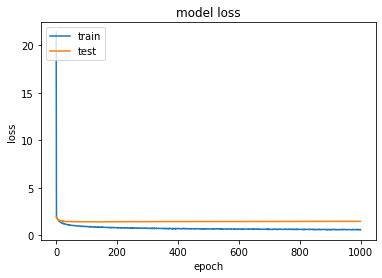

In [92]:
# Plotting the model loss

plt.plot(cnn_model.history['loss'])
plt.plot(cnn_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


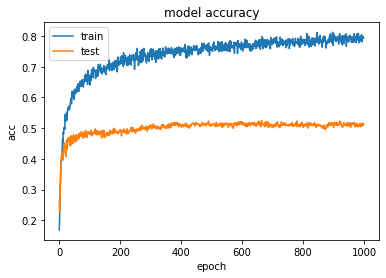

In [93]:
# Plotting model accuracy

plt.plot(cnn_model.history['accuracy'])
plt.plot(cnn_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [94]:
predictions = model.predict_classes(x_testcnn)

In [95]:
predictions

array([0, 7, 7, 6, 2, 2, 4, 7, 3, 2, 2, 2, 6, 3, 7, 1, 5, 7, 4, 4, 5, 4,
       3, 7, 3, 5, 7, 1, 3, 1, 3, 3, 4, 2, 1, 0, 4, 7, 7, 5, 1, 4, 1, 6,
       2, 2, 7, 3, 2, 7, 3, 5, 7, 2, 4, 7, 7, 6, 3, 5, 6, 3, 1, 3, 1, 5,
       3, 2, 5, 3, 5, 4, 3, 5, 7, 3, 7, 6, 6, 4, 2, 4, 4, 3, 7, 1, 7, 5,
       3, 4, 7, 3, 7, 3, 4, 2, 3, 0, 7, 6, 5, 5, 5, 5, 1, 5, 3, 5, 5, 7,
       7, 4, 7, 7, 1, 7, 5, 5, 1, 2, 7, 5, 5, 5, 7, 4, 4, 2, 3, 7, 1, 7,
       7, 4, 6, 7, 7, 5, 3, 1, 7, 6, 6, 1, 7, 1, 0, 6, 7, 4, 6, 6, 6, 1,
       1, 6, 4, 1, 4, 1, 5, 7, 5, 7, 6, 7, 5, 3, 3, 4, 5, 5, 2, 0, 5, 3,
       5, 2, 6, 1, 6, 6, 7, 5, 6, 7, 1, 6, 4, 4, 7, 5, 5, 6, 7, 3, 6, 1,
       4, 0, 1, 1, 6, 1, 6, 6, 6, 1, 2, 5, 5, 2, 1, 5, 1, 7, 4, 1, 6, 1,
       4, 0, 2, 1, 1, 5, 1, 6, 0, 1, 5, 1, 6, 3, 4, 2, 3, 5, 1, 6, 4, 7,
       1, 6, 6, 4, 4, 1, 7, 4, 2, 6, 3, 5, 1, 1, 7, 4, 5, 7, 5, 7, 3, 1,
       6, 1, 7, 3, 3, 0, 1, 4, 7, 2, 6, 5, 7, 4, 3, 4, 2, 2, 1, 7, 1, 5,
       7, 6, 1, 3, 3, 7, 2, 4, 7, 7, 4, 6, 3, 5, 1,

In [96]:
y_test

array([1, 7, 6, 7, 7, 2, 4, 7, 0, 5, 2, 5, 4, 1, 7, 1, 5, 7, 4, 7, 5, 4,
       6, 5, 3, 2, 7, 1, 0, 1, 2, 0, 6, 2, 1, 1, 4, 7, 3, 5, 1, 4, 1, 6,
       2, 5, 7, 1, 4, 7, 2, 3, 4, 2, 6, 7, 7, 2, 3, 5, 5, 0, 1, 2, 2, 6,
       0, 2, 5, 0, 5, 3, 3, 5, 6, 5, 2, 6, 2, 4, 7, 4, 2, 4, 7, 3, 7, 5,
       6, 6, 6, 5, 7, 1, 1, 2, 3, 2, 7, 3, 2, 4, 5, 5, 7, 5, 5, 5, 6, 7,
       6, 6, 0, 6, 0, 6, 5, 5, 1, 1, 7, 3, 5, 5, 7, 4, 4, 7, 3, 7, 1, 7,
       5, 4, 6, 7, 5, 3, 3, 2, 7, 6, 4, 1, 7, 4, 1, 6, 4, 4, 6, 0, 6, 1,
       0, 6, 4, 1, 4, 3, 5, 6, 3, 0, 6, 3, 2, 3, 3, 6, 3, 5, 5, 6, 5, 7,
       3, 2, 5, 1, 6, 6, 7, 2, 3, 7, 1, 4, 3, 7, 7, 5, 3, 6, 6, 1, 6, 1,
       6, 0, 0, 2, 7, 3, 6, 6, 3, 0, 4, 5, 6, 6, 1, 5, 1, 7, 1, 3, 4, 6,
       4, 1, 4, 1, 1, 4, 1, 6, 3, 1, 2, 6, 6, 3, 2, 2, 3, 5, 3, 3, 4, 7,
       1, 6, 6, 4, 2, 1, 3, 2, 3, 6, 6, 5, 1, 4, 7, 4, 5, 3, 5, 4, 1, 3,
       6, 1, 2, 1, 3, 1, 1, 4, 2, 5, 6, 2, 7, 4, 7, 2, 2, 2, 0, 7, 0, 4,
       7, 5, 1, 2, 7, 3, 5, 6, 1, 7, 2, 6, 2, 2, 1,

In [97]:
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.18      0.11      0.14        27
           1       0.55      0.65      0.60        57
           2       0.48      0.39      0.43        57
           3       0.37      0.32      0.34        56
           4       0.56      0.62      0.59        55
           5       0.61      0.64      0.62        61
           6       0.55      0.48      0.51        62
           7       0.53      0.68      0.60        57

    accuracy                           0.51       432
   macro avg       0.48      0.49      0.48       432
weighted avg       0.50      0.51      0.50       432

[[ 3  9  3  7  1  0  1  3]
 [ 7 37  2  7  2  0  1  1]
 [ 1  4 22  5  9  7  4  5]
 [ 2 11  1 18  2 11  6  5]
 [ 0  2  3  2 34  3  6  5]
 [ 0  1  9  3  0 39  4  5]
 [ 2  2  2  4  9  3 30 10]
 [ 2  1  4  3  4  1  3 39]]
